In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import sympy

import sympy_utils
from sympy_utils import short_latex, ShortLatexPrinter, matsym, vec, dynvec, SympyDumpable

import model
from model import Model
import algorithms
from algorithms import StaticLinearization, DynamicLinearization

sympy.init_session(latex_printer=short_latex)

IPython console for SymPy 1.3 (Python 3.7.2-64-bit) (ground types: gmpy)

These commands were executed:
>>> from __future__ import division
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at http://docs.sympy.org/1.3/



In [2]:
# configure matplotlib
plt.ion()
rc_params = {
    'figure.figsize': (12, 7),
    'axes.grid': True,
# use tight layout by default
    'figure.autolayout': True,
# don't show spines
    'axes.spines.bottom': False,
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
# LaTeX fonts
#     'text.usetex': True,
#     'font.family': 'serif',
#     'font.size': 12,
}

plt.rcParams.update(rc_params)

# igonre warnings from tight layout
import warnings
warnings.filterwarnings('ignore',
    message=r'This figure includes Axes that are not compatible with tight_layout',
    category=UserWarning)

In [3]:
# import model data from file
mapping = [
    ('full_1', Model),
    ('full_1_static', StaticLinearization),
    ('full_1_dynamic', DynamicLinearization),
    ('full_2', Model),
    ('full_2_static', StaticLinearization),
    ('full_2_dynamic', DynamicLinearization),
    ('full_2_JPTD', Model),
    ('full_2_JPTD_static', StaticLinearization),
    ('full_2_JPTD_dynamic', DynamicLinearization),
    ('simplified', Model),
    ('simplified_static', StaticLinearization),
    ('simplified_dynamic_1', DynamicLinearization),
    ('simplified_dynamic_2', DynamicLinearization),
]

models = SympyDumpable.load('generated_models.json', mapping)

In [4]:
R, l = model.R, model.l
eta = model.eta

---
---

In [88]:
m = models['full_1']
alg = models['full_1_static']

hd_sym = matsym('h_d', alg.h)
dhd_sym = matsym('dh_d', alg.h)
K = eye(5)

# control algorithm
u = dhd_sym - K * (alg.h - hd_sym)
eta = alg.D_inv * u

# simulate the object
dq = m.G * eta
dq.simplify()

⎡     1             0             0                  0                      0 
⎢                                                                             
⎢     0             1             0                  0                      0 
⎢                                                                             
⎢     0             0             1                  0                      0 
⎢                                                                             
⎢ sin(θ₀(t))   -cos(θ₀(t))                                                    
⎢ ──────────   ────────────       0             -sin(θ₁(t))                 0 
⎢     R             R                                                         
⎢                                                                             
⎢ cos(θ₀(t))    sin(θ₀(t))                                                    
⎢────────────  ────────────       0        cos(θ₁(t))⋅tan(φ₁(t))            0 
⎢R⋅cos(φ₁(t))  R⋅cos(φ₁(t))                         

In [89]:
dq = dq.subs({R: Rational(3, 10), l: Rational(5, 10)}).simplify()
vec_in = 
# ode = lambdify((m.q, t), dq, 'numpy')
# dq


⎡      1               0              0                  0                    
⎢                                                                             
⎢      0               1              0                  0                    
⎢                                                                             
⎢      0               0              1                  0                    
⎢                                                                             
⎢10⋅sin(θ₀(t))  -10⋅cos(θ₀(t))                                                
⎢─────────────  ───────────────       0             -sin(θ₁(t))               
⎢      3               3                                                      
⎢                                                                             
⎢10⋅cos(θ₀(t))   10⋅sin(θ₀(t))                                                
⎢─────────────   ─────────────        0        cos(θ₁(t))⋅tan(φ₁(t))          
⎢ 3⋅cos(φ₁(t))    3⋅cos(φ₁(t))                      

---
---

In [63]:
def extend_lambdified_constants(vec_arr, length):
    """
    Lambdify called on numpy vectors doesn't seem to return normal numpy 2D arrays.
    This function tries to convert the output vector that should be 2D when called with
    an array input. When some coulmn is constant (so SymPy returns just 1 number) it is
    broadcasted to the whole column of output matrix.
    """
    new = np.empty([length, len(vec_arr)])
    for col in range(len(vec_arr)):
        try:
            new[:, col] = vec_arr[col][0].astype(np.float)
        except:
            new[:, col] = vec_arr[col].astype(np.float)
    return new

In [72]:
# trajectory
# xd = sin(t/2)
# yd = cos(t + pi/4)
xd = cos(t)
yd = sin(t)
thetad = atan2(yd.diff(t), xd.diff(t))
# thetad = atan(yd.diff(t) / xd.diff(t))
# thetad = 0 * t + pi/4
psi1d = 0 * t + 1
psi2d = psi1d

hd = vec(xd, yd, thetad, psi1d, psi2d)

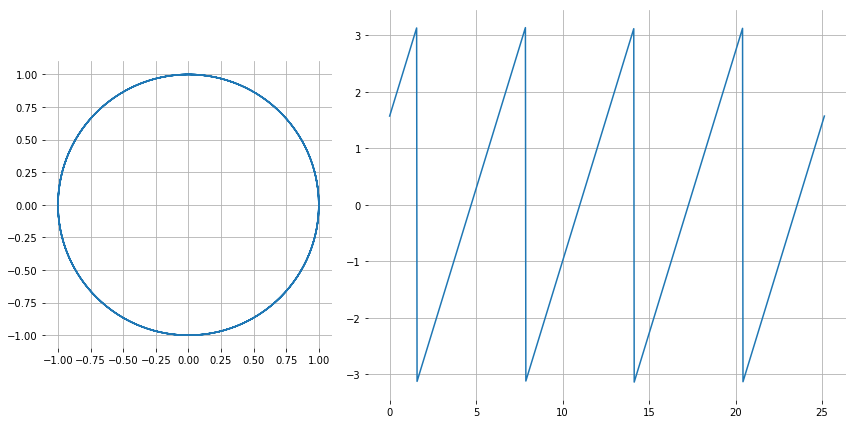

In [73]:
tt = np.linspace(0, 2 * 4*np.pi, 1000)

hd_func = lambdify(t, hd, 'numpy')
hd_values = extend_lambdified_constants(hd_func(tt), len(tt))
# hdd = np.array([hd_func(ti) for ti in tt]).squeeze()

fig, ax = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [1.5, 2.5]})
ax[0].plot(hd_values[:, 0], hd_values[:, 1])
ax[0].set_aspect('equal')
ax[1].plot(tt, hd_values[:, 2]);

---

In [9]:
m = models['full_1']
alg = models['full_1_static']

K = eye(5)

# control algorithm
u = dhd - K * (alg.h - hd)
eta = alg.D_inv * u

# simulate the object
dq = m.G * eta

In [10]:
dq = dq.subs({R: Rational(3, 10), l: Rational(5, 10)}).simplify()
ode = lambdify((m.q, t), dq, 'numpy')
dq

⎡                                                                     ⎛    π⎞ 
⎢                                                       -x(t) + √2⋅cos⎜t + ─⎟ 
⎢                                                                     ⎝    4⎠ 
⎢                                                                             
⎢                                                                     ⎛    π⎞ 
⎢                                                       -y(t) + √2⋅sin⎜t + ─⎟ 
⎢                                                                     ⎝    4⎠ 
⎢                                                                             
⎢                                                                      π      
⎢                                                             -θ₀(t) + ─      
⎢                                                                      4      
⎢                                                                             
⎢                                                   

In [11]:
J = dq.jacobian(m.q).as_immutable().simplify()
J_fun = lambdify((m.q, t), J, 'numpy')
J

⎡      -1                0                                           0        
⎢                                                                             
⎢       0               -1                                           0        
⎢                                                                             
⎢       0                0                                          -1        
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢-10⋅sin(θ₀(t))    10⋅cos(θ₀(t))     10⋅x(t)⋅cos(θ₀(t))   10⋅y(t)⋅sin(θ₀(t))  
⎢───────────────   ─────────────   - ────────────────── - ────────────────── +
⎢       3                3                   3                    3           
⎢                                                                             
⎢                                        ⎛          

CPU times: user 111 ms, sys: 3.26 ms, total: 114 ms
Wall time: 113 ms
Number of function evaluations: 0, number of Jacobian evaluations: 1948906752


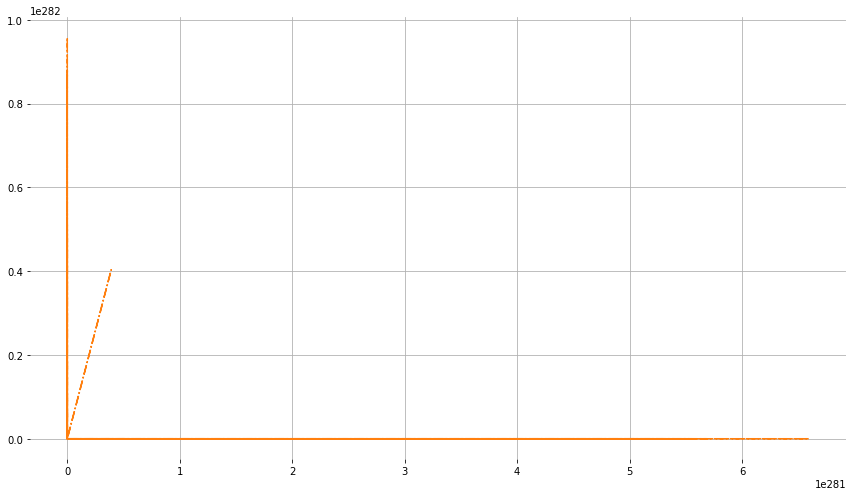

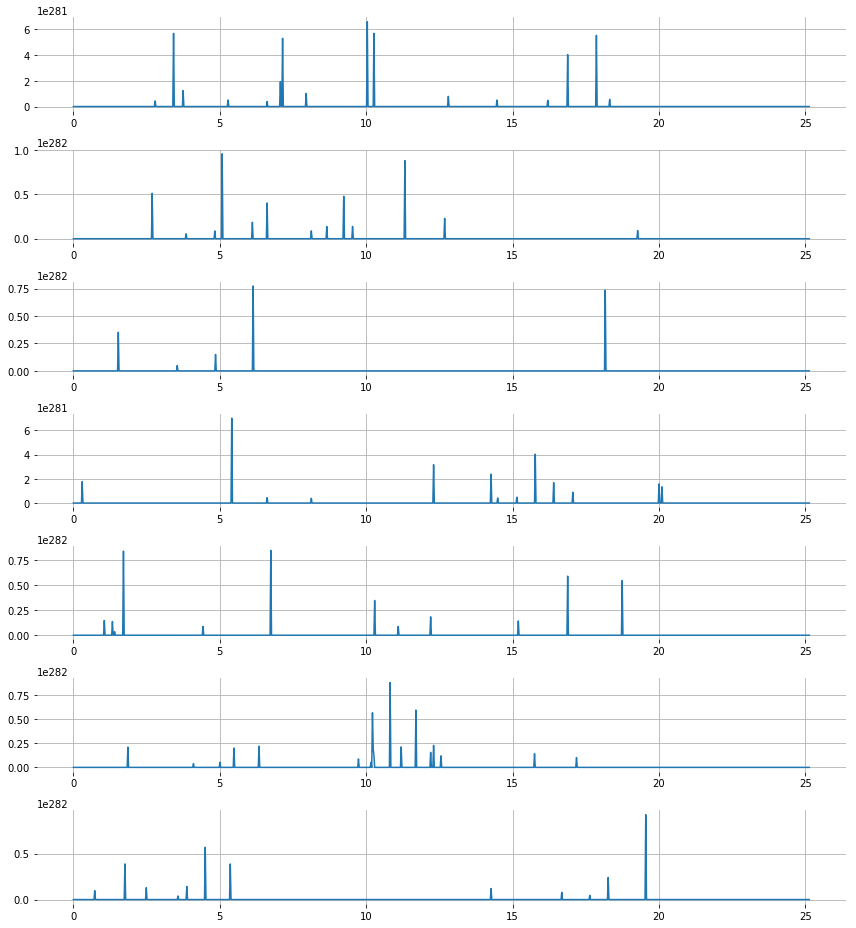

In [16]:
from scipy.integrate import odeint
%matplotlib inline

ode2 = lambda q, t: ode(q, t)[:, 0]

q0 = np.ones(9) * np.random.randn(9)
# %time q, info = odeint(ode2, q0, tt, Dfun=J_fun, full_output=True, printmessg=True)
%time q, info = odeint(ode2, q0, tt, full_output=True, printmessg=True)

print("Number of function evaluations: %d, number of Jacobian evaluations: %d" % (info['nfe'][-1], info['nje'][-1]))

plt.figure(figsize=(12, 7))
plt.plot(hdd[:, 0], hdd[:, 1], 'C0')
plt.plot(q[:, 0], q[:, 1], '-.C1')
plt.grid(True)

fig, ax = plt.subplots(7, 1, figsize=(12, 13))
for i in range(7):
    ax[i].plot(tt, q[:, i])